In [1]:
from pylab import *
%matplotlib inline
caffe_root = '../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

from caffe import layers as L, params as P
caffe.set_mode_cpu()


Iteration 0 testing...
test acc: 0.0007
test acc: 0.0018
test acc: 0.0026
test acc: 0.0042
test acc: 0.0051
test acc: 0.0058
test acc: 0.0067
test acc: 0.0077
test acc: 0.0084
test acc: 0.0092
test acc: 0.0104
test acc: 0.0115
test acc: 0.0126
test acc: 0.0135
test acc: 0.0147
test acc: 0.0154
test acc: 0.0165
test acc: 0.0171
test acc: 0.0182
test acc: 0.0198
test acc: 0.0209
test acc: 0.0223
test acc: 0.0232
test acc: 0.0238
test acc: 0.0244
test acc: 0.0262
test acc: 0.0276
test acc: 0.0283
test acc: 0.0289
test acc: 0.0303
test acc: 0.0314
test acc: 0.0328
test acc: 0.0335
test acc: 0.0347
test acc: 0.0355
test acc: 0.0369
test acc: 0.0379
test acc: 0.039
test acc: 0.04
test acc: 0.0416
test acc: 0.0422
test acc: 0.0426
test acc: 0.0439
test acc: 0.0457
test acc: 0.0459
test acc: 0.0469
test acc: 0.0476
test acc: 0.0484
test acc: 0.0494
test acc: 0.05
test acc: 0.0506
test acc: 0.0517
test acc: 0.0525
test acc: 0.0537
test acc: 0.0543
test acc: 0.0551
test acc: 0.0559
test acc: 0.0

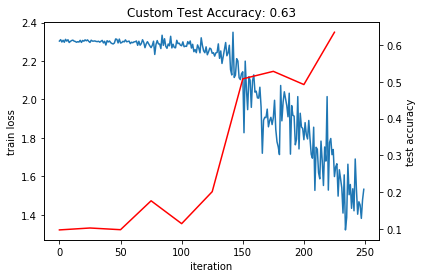

In [21]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

def conv_relu(bottom, ks, nout, strid=1, pad=0):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                        num_output=nout, pad=pad)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.Max, kernel_size=ks, stride=stride)

    
def custom_net(lmdb, batch_size):
    n = caffe.NetSpec()
    #n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb, transform_param=dict(scale=1./255), ntop=2)
    n.data, n.label = L.Data(source=lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=2,
                        transform_param=dict(crop_size=24, scale=1./255, mirror=False))
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=128, pad=1, stride=1, 
                            param=[{'lr_mult':1, 'decay_mult':1},
                                   {'lr_mult':2, 'decay_mult':0}],
                            weight_filler=dict(type='msra'))
    n.bn1 = L.BatchNorm(n.conv1, in_place=True)
    n.scale1 = L.Scale(n.conv1, bias_term=True, in_place=True)
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.dropout1 = L.Dropout(n.conv1, dropout_ratio=0.25, in_place=True)
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.conv2 = L.Convolution(n.pool1, kernel_size=3, num_output=128, pad=1, stride=1,
                            param=[{'lr_mult':1, 'decay_mult':1},
                                   {'lr_mult':2, 'decay_mult':0}],
                            weight_filler=dict(type='msra'))
    n.bn2 = L.BatchNorm(n.conv2, in_place=True)
    n.scale2 = L.Scale(n.conv2, bias_term=True, in_place=True)
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.dropout2 = L.Dropout(n.conv2, dropout_ratio=0.25, in_place=True)
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.fc1 = L.InnerProduct(n.pool2, num_output=128, weight_filler=dict(type='msra'), bias_filler=dict(type='constant'))
    n.relu_fc1 = L.ReLU(n.fc1, in_place=True)
    n.dropout = L.Dropout(n.relu_fc1, dropout_ratio=0.25, in_place=True)
    
    n.score = L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='msra'), bias_filler=dict(type='constant'))
    
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()
"""
with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))
"""    
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

s.random_seed = 0xCAFFE

s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500
s.test_iter.append(100)
s.max_iter = 10000

s.type = "SGD" # "Adam", "Nesterov"
s.base_lr = 0.01
s.momentum = 0.9
s.weight_decay = 5e-4

s.lr_policy = 'inv' # 'fixed'
s.gamma = 0.0001
s.power = 0.75

s.display = 1000

s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

s.solver_mode = caffe_pb2.SolverParameter.CPU

with open(solver_config_path, 'w') as f:
    f.write(str(s))
    
solver = None
solver = caffe.get_solver(solver_config_path)

niter = 250
test_interval = niter / 10
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
#lr = zeros(niter)

for it in range(niter):
    solver.step(1)
    train_loss[it] = solver.net.blobs['loss'].data
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            test_acc[it // test_interval] = correct / 1e4
            print 'test acc:', correct / 1e4
        
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))
